# Finding best hyperparameters for emu_v0

Deciding which hyperparameters are the best for emu_v0

In [1]:
# %load first_cell.py
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

import numpy as np
import os
import sys
import matplotlib.pyplot as plt

from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=67.26, Om0=0.314, Ob0=0.049)

from matplotlib import rcParams
rcParams["mathtext.fontset"] = "stix"
rcParams["font.family"] = "STIXGeneral"


def print_shape(*args):
    nelem = len(args)
    for ii in range(nelem - 1):
        print(args[ii].shape, end=" ")
    print(args[nelem - 1].shape)


def ls_level(folder, nlevels):
    for ii in range(nlevels):
        folder = os.path.dirname(folder)
    folder += "/"
    return folder


path_program = ls_level(os.getcwd(), 1)
print(path_program)
sys.path.append(path_program)

DEBUG:jupyter_black:config: {'line_length': 79, 'target_versions': {<TargetVersion.PY310: 10>}}


/home/jchaves/Proyectos/projects/lya/lya_pk/


In [2]:
from lya_pk.archive import GadgetArchive3D
from lya_pk.emulator_p3d import P3DEmulator

## Load training data

In [3]:
%%time
folder_lya_data = path_program + "data/best_arinyo/"

Archive3D = GadgetArchive3D(
    base_folder=path_program, folder_data=folder_lya_data
)
print(len(Archive3D.training_data))

1650
CPU times: user 11.8 s, sys: 245 ms, total: 12 s
Wall time: 12 s


## Training

### Variance between training sets

In [25]:
niter = 5
res = []

for ii in range(niter):
    print(ii + 1, " out of ", niter)
    p3d_emu = P3DEmulator(
        Archive3D.training_data,
        Archive3D.emu_params,
        target_space="Arinyo",
        nepochs=100,
        lr=0.01,
        batch_size=100,
        step_size=75,
        gamma=0.01,
        nhidden=2,
        adamw=True,
    )
    arr = np.array(p3d_emu.loss_arr)
    res.append(np.mean(arr, axis=1))

1  out of  5
Emualtor trained in 4.196445941925049 seconds
2  out of  5
Emualtor trained in 4.60146164894104 seconds
3  out of  5
Emualtor trained in 7.6163389682769775 seconds
4  out of  5
Emualtor trained in 7.213541507720947 seconds
5  out of  5
Emualtor trained in 6.133575916290283 seconds


<IPython.core.display.Javascript object>


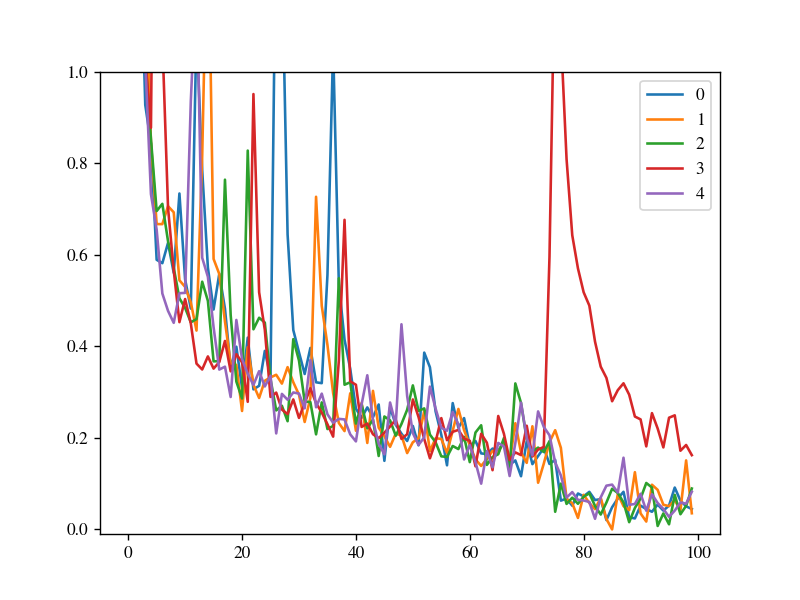

In [27]:
bot = np.min(res)
for ii in range(5):
    plt.plot(res[ii] - bot, label=str(ii))
plt.ylim([-0.01, 1])
plt.legend()

### Learning rate

best = 0.01

In [28]:
niter = 4
lr_values = np.array([1e-4, 1e-3, 1e-2, 5e-2])
res_lr = []

for ii in range(niter):
    print(ii + 1, " out of ", niter)
    p3d_emu = P3DEmulator(
        Archive3D.training_data,
        Archive3D.emu_params,
        target_space="Arinyo",
        nepochs=100,
        lr=lr_values[ii],
    )
    arr = np.array(p3d_emu.loss_arr)
    res_lr.append(np.mean(arr, axis=1))

1  out of  4
Emualtor trained in 4.114951848983765 seconds
2  out of  4
Emualtor trained in 4.646910905838013 seconds
3  out of  4
Emualtor trained in 4.669064998626709 seconds
4  out of  4
Emualtor trained in 4.948115110397339 seconds


18.288258272058822
19.334348117603977


<IPython.core.display.Javascript object>


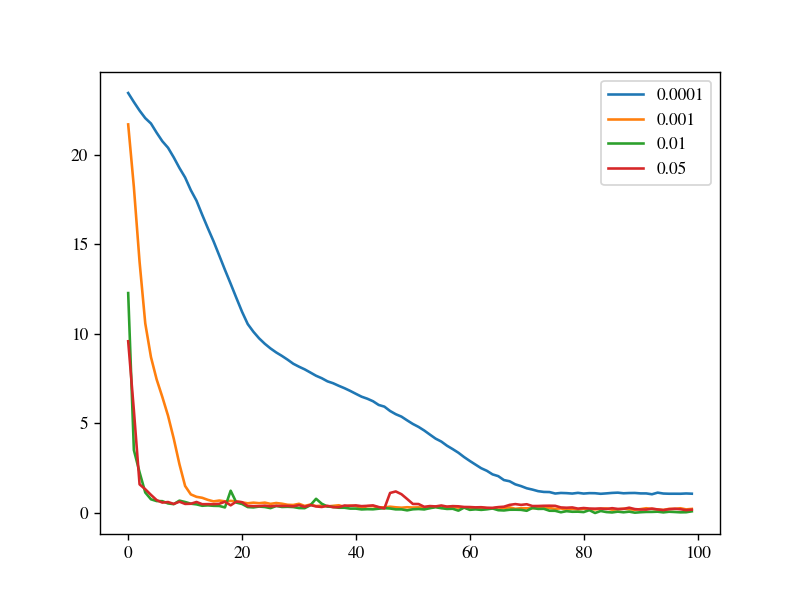

18.45647363101735
18.288258272058822
18.448018130134134


In [40]:
bot = np.min(res_lr)
print(bot)
for ii in range(len(lr_values)):
    print(res_lr[ii].min())
    plt.plot(res_lr[ii] - bot, label=str(lr_values[ii]))
plt.legend()

### AdamW

In [4]:
niter = 2
adamw_values = np.array([False, True])
res_adamw = []

for ii in range(niter):
    print(ii + 1, " out of ", niter)
    p3d_emu = P3DEmulator(
        Archive3D.training_data,
        Archive3D.emu_params,
        target_space="Arinyo",
        nepochs=100,
        lr=0.01,
        batch_size=100,
        step_size=75,
        gamma=0.1,
        weight_decay=0.01,
        nhidden=2,
        adamw=adamw_values[ii],
    )
    arr = np.array(p3d_emu.loss_arr)
    res_adamw.append(np.mean(arr, axis=1))

1  out of  2
Emualtor trained in 9.860491752624512 seconds
2  out of  2
Emualtor trained in 6.096420764923096 seconds


18.29671568029067


<IPython.core.display.Javascript object>


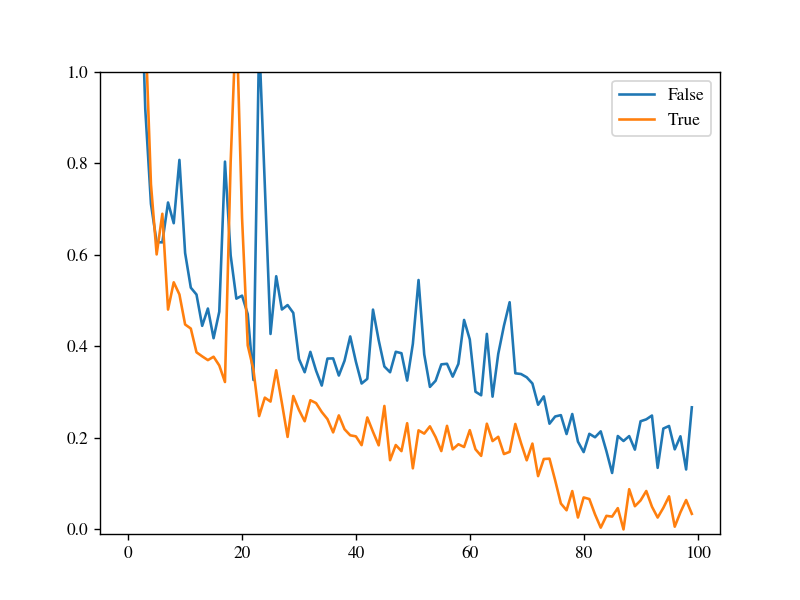

In [6]:
bot = np.min(res_adamw)
print(bot)
for ii in range(len(res_adamw)):
    plt.plot(res_adamw[ii] - bot, label=str(adamw_values[ii]))
plt.ylim([-0.01, 1])
plt.legend()

### AMSGrad

In [4]:
niter = 2
amsgrad_values = np.array([False, True])
res_amsgrad = []

for ii in range(niter):
    print(ii + 1, " out of ", niter)
    p3d_emu = P3DEmulator(
        Archive3D.training_data,
        Archive3D.emu_params,
        target_space="Arinyo",
        nepochs=100,
        lr=0.01,
        amsgrad=amsgrad_values[ii],
    )
    arr = np.array(p3d_emu.loss_arr)
    res_amsgrad.append(np.mean(arr, axis=1))

1  out of  2
Emualtor trained in 20.022753715515137 seconds
2  out of  2
Emualtor trained in 25.694119215011597 seconds


18.222544277415555


<IPython.core.display.Javascript object>


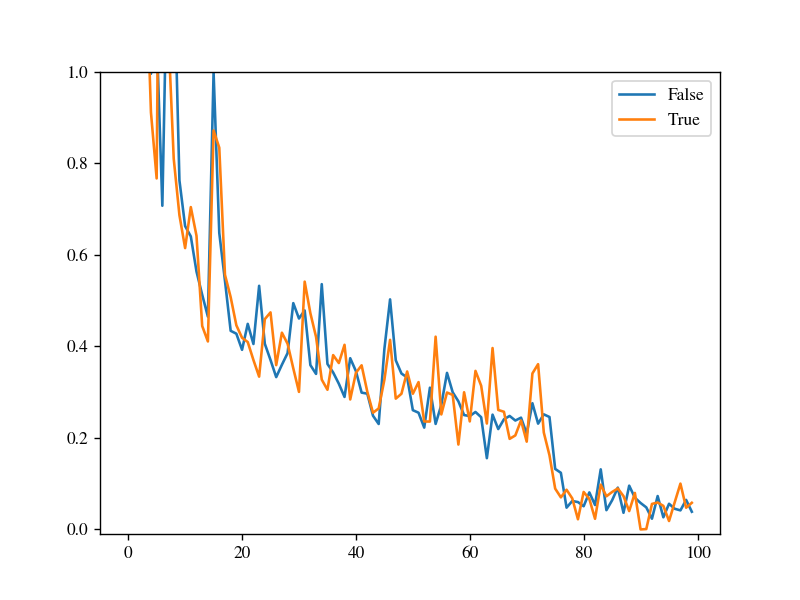

In [6]:
bot = np.min(res_amsgrad)
print(bot)
for ii in range(len(res_amsgrad)):
    plt.plot(res_amsgrad[ii] - bot, label=str(amsgrad_values[ii]))
plt.ylim([-0.01, 1])
plt.legend()

### Batch_size

best 100

In [9]:
niter = 4
batch_values = np.array([25, 50, 100, 200])
res_batch = []

for ii in range(niter):
    print(ii + 1, " out of ", niter)
    p3d_emu = P3DEmulator(
        Archive3D.training_data,
        Archive3D.emu_params,
        target_space="Arinyo",
        nepochs=100,
        lr=0.01,
        batch_size=int(batch_values[ii]),
    )
    arr = np.array(p3d_emu.loss_arr)
    res_batch.append(np.mean(arr, axis=1))

1  out of  4
Emualtor trained in 21.306399822235107 seconds
2  out of  4
Emualtor trained in 25.702837228775024 seconds
3  out of  4
Emualtor trained in 9.609158754348755 seconds
4  out of  4
Emualtor trained in 7.380205154418945 seconds


<IPython.core.display.Javascript object>


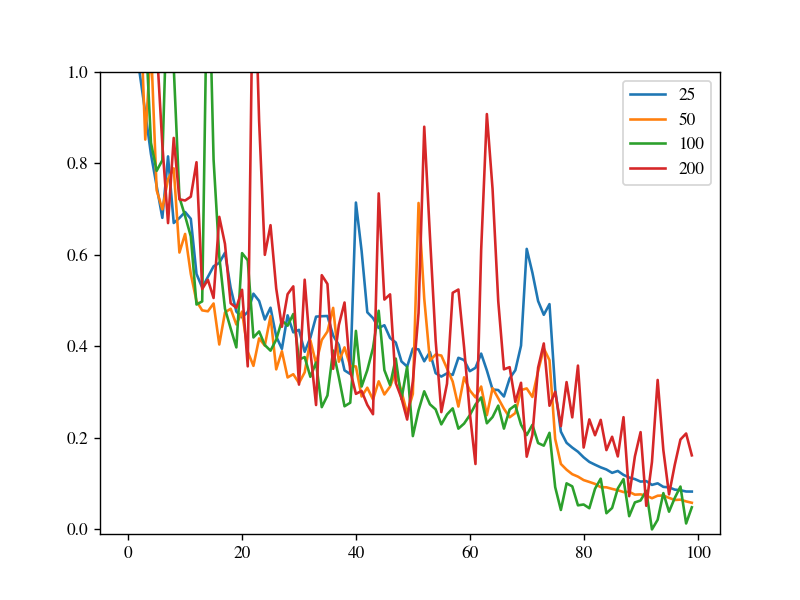

In [10]:
bot = np.min(res_batch)
for ii in range(len(batch_values)):
    plt.plot(res_batch[ii] - bot, label=str(batch_values[ii]))
plt.ylim([-0.01, 1])
plt.legend()

### Decay step

best 75

In [13]:
niter = 4
step_values = np.array([25, 50, 75, 100])
res_step = []

for ii in range(niter):
    print(ii + 1, " out of ", niter)
    p3d_emu = P3DEmulator(
        Archive3D.training_data,
        Archive3D.emu_params,
        target_space="Arinyo",
        nepochs=100,
        lr=0.01,
        batch_size=25,
        weight_decay=0.01,
        adamw=True,
        step_size=int(step_values[ii]),
    )
    arr = np.array(p3d_emu.loss_arr)
    res_step.append(np.mean(arr, axis=1))

1  out of  4
Emualtor trained in 7.97296404838562 seconds
2  out of  4
Emualtor trained in 8.422423839569092 seconds
3  out of  4
Emualtor trained in 8.835186243057251 seconds
4  out of  4
Emualtor trained in 8.967929601669312 seconds


<IPython.core.display.Javascript object>


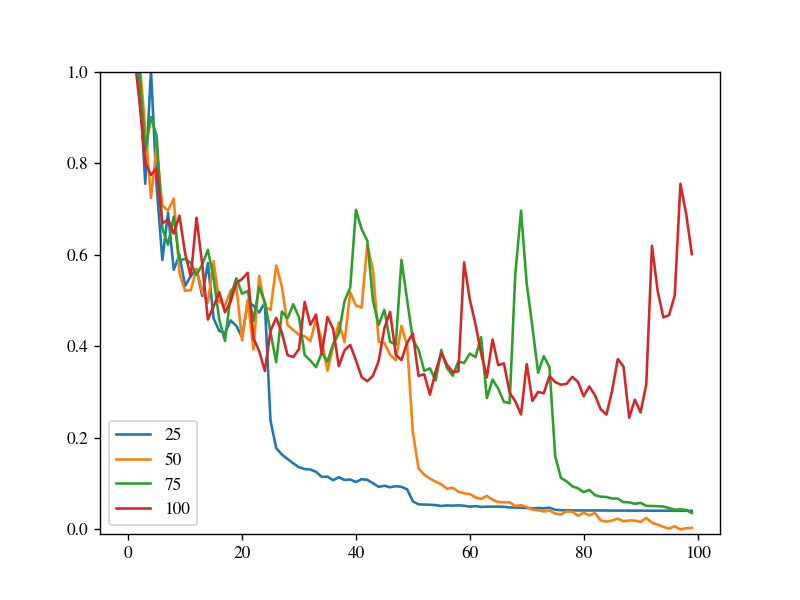

In [14]:
bot = np.min(res_step)
for ii in range(len(step_values)):
    plt.plot(res_step[ii] - bot, label=str(step_values[ii]))
plt.ylim([-0.01, 1])
plt.legend()

### Decay gamma

best 0.1

In [42]:
niter = 3
gamma_values = np.array([0.01, 0.1, 1])
res_gamma = []

for ii in range(niter):
    print(ii + 1, " out of ", niter)
    p3d_emu = P3DEmulator(
        Archive3D.training_data,
        Archive3D.emu_params,
        target_space="Arinyo",
        nepochs=100,
        lr=0.01,
        batch_size=100,
        step_size=75,
        nhidden=2,
        gamma=gamma_values[ii],
    )
    arr = np.array(p3d_emu.loss_arr)
    res_gamma.append(np.mean(arr, axis=1))

1  out of  3
Emualtor trained in 5.114652872085571 seconds
2  out of  3
Emualtor trained in 8.703951358795166 seconds
3  out of  3
Emualtor trained in 7.247984170913696 seconds


<IPython.core.display.Javascript object>


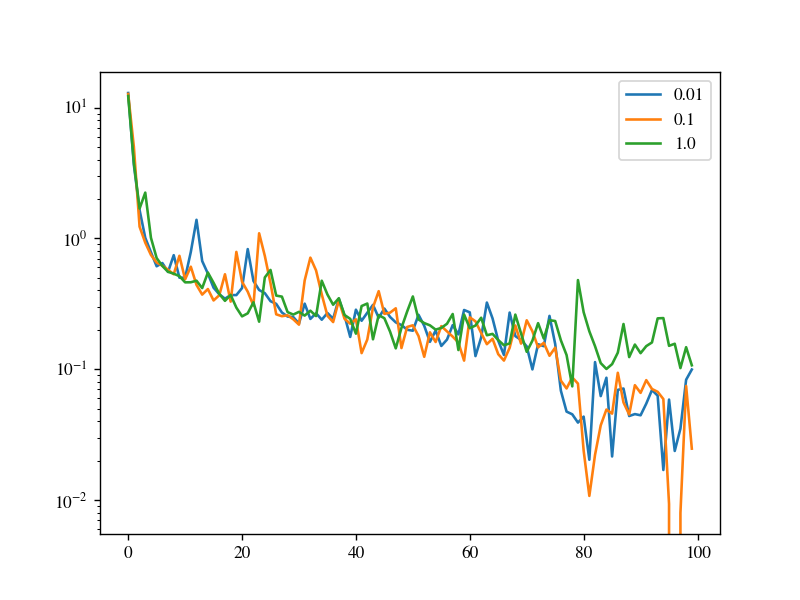

In [43]:
bot = np.min(res_gamma)
for ii in range(len(gamma_values)):
    plt.plot(res_gamma[ii] - bot, label=str(gamma_values[ii]))
# plt.ylim([-0.01, 1])
plt.legend()

### Weight decay
0

In [10]:
niter = 4
wd_values = np.array([1e-1, 1e-2, 1e-3, 1e-4])
res_wd = []

for ii in range(niter):
    print(ii + 1, " out of ", niter)
    p3d_emu = P3DEmulator(
        Archive3D.training_data,
        Archive3D.emu_params,
        target_space="Arinyo",
        nepochs=100,
        lr=0.01,
        batch_size=100,
        step_size=75,
        nhidden=2,
        gamma=0.1,
        weight_decay=wd_values[ii],
        adamw=True,
    )
    arr = np.array(p3d_emu.loss_arr)
    res_wd.append(np.mean(arr, axis=1))

1  out of  4
Emualtor trained in 5.558553457260132 seconds
2  out of  4
Emualtor trained in 5.189563035964966 seconds
3  out of  4
Emualtor trained in 4.994006872177124 seconds
4  out of  4
Emualtor trained in 4.832410097122192 seconds


18.26957882151884


<IPython.core.display.Javascript object>


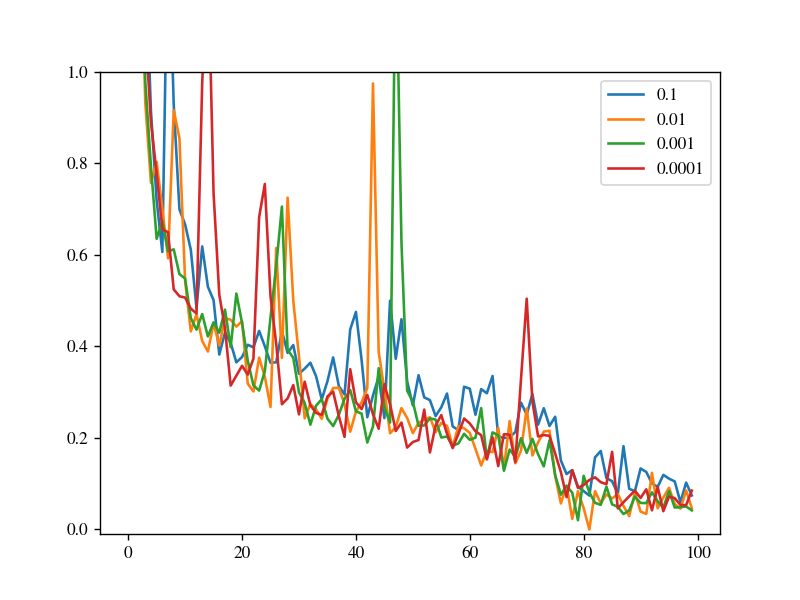

In [12]:
bot = np.min(res_wd)
print(bot)
for ii in range(len(wd_values)):
    plt.plot(res_wd[ii] - bot, label=str(wd_values[ii]))
plt.ylim([-0.01, 1])
plt.legend()

### Hidden layers
2

In [49]:
niter = 3
nh_values = np.array([2, 3, 5])
res_nh = []

for ii in range(niter):
    print(ii + 1, " out of ", niter)
    p3d_emu = P3DEmulator(
        Archive3D.training_data,
        Archive3D.emu_params,
        target_space="Arinyo",
        nepochs=100,
        lr=0.01,
        batch_size=100,
        step_size=75,
        gamma=0.1,
        weight_decay=0,
        nhidden=int(nh_values[ii]),
    )
    arr = np.array(p3d_emu.loss_arr)
    res_nh.append(np.mean(arr, axis=1))

1  out of  3
Emualtor trained in 4.299788475036621 seconds
2  out of  3
Emualtor trained in 4.645781517028809 seconds
3  out of  3
Emualtor trained in 6.532171726226807 seconds


<IPython.core.display.Javascript object>


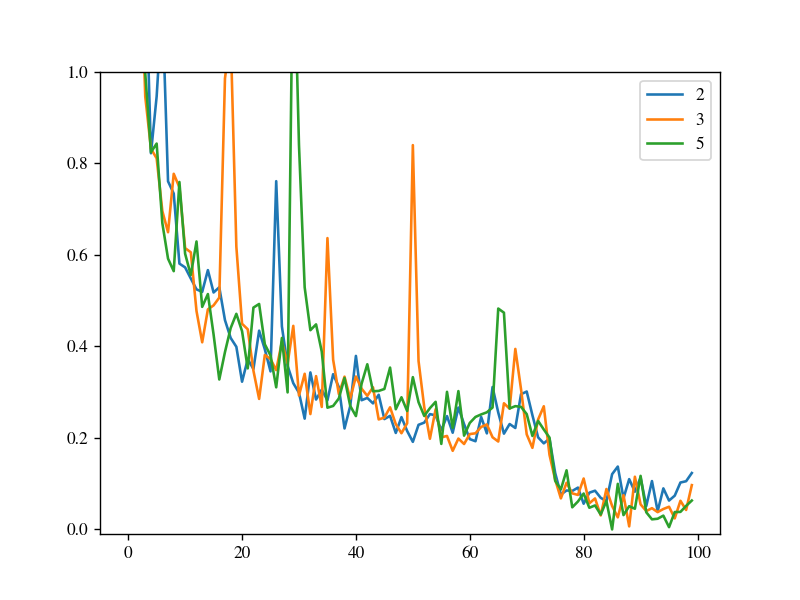

In [52]:
bot = np.min(res_nh)
for ii in range(len(nh_values)):
    plt.plot(res_nh[ii] - bot, label=str(nh_values[ii]))
plt.ylim([-0.01, 1])
plt.legend()